Ultralytics contains a variety of models that can lead to some very specific customizations. Within this project we have explored the ways one may customize and tune yolov10 model m and yolov10 mode b. yolo10m was utilized in the traditional YOLO tasks of object detection and classification, while yolo10b was tuned for specifically object classification. The script named architecture_and_hyperparameters.py within the jordan branch handled data selection, model training, and inference. Within this notebook we present the results as well as the tuning we made to the YOLOv10 model.

yolo10m: object detection and classification

In [ ]:
# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# YOLOv10m object detection model with P3/8 - P5/32 outputs
# Model docs: https://docs.ultralytics.com/models/yolov10
# Task docs: https://docs.ultralytics.com/tasks/detect

# Parameters
# -------------------------------------------------------------
#  YOLO‑v10 m  •  2 classes  •  CBAM after backbone
# -------------------------------------------------------------
#nc: 2
scales:
  m: [0.67, 0.75, 1024]        # depth, width, max_ch

backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv,        [64,   3, 2]]         # 0  P1/2
  - [-1, 1, Conv,        [128,  3, 2]]         # 1  P2/4
  - [-1, 5, C2f,         [128, True]]          # 2
  - [-1, 1, Conv,        [256,  3, 2]]         # 3  P3/8
  - [-1, 8, C2f,         [256, True]]          # 4
  - [-1, 1, nn.Dropout2d,[0.1]]                # 5
  - [-1, 1, SCDown,      [512,  3, 2]]         # 6  P4/16
  - [-1, 8, C2f,         [512, True]]          # 7
  - [-1, 1, SCDown,      [1024, 3, 2]]         # 8  P5/32
  - [-1, 5, C2fCIB,      [1024, True]]         # 9
  - [-1, 1, PSA,         [1024]]               # 10
  - [-1, 1, SPPF,        [1024, 5]]            # 11
  - [-1, 1, PSA,         [1024]]               # 12
  # ---------- NEW: attention block ----------
  # 1024×0.75 = 768 real channels, so pass 768
  - [-1, 1, CBAM,        [768]]                # 13
  # ------------------------------------------

head:
  # P5 → P4
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]] # 14
  - [[-1,  6], 1, Concat, [1]]                 # 15  (768 + 384)  P4
  - [-1, 3, C2f,        [512]]                 # 16

  # P4 → P3
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]] # 17
  - [[-1, 4], 1, Concat, [1]]                  # 18  (512 + 192)  P3
  - [-1, 3, C2f,        [256]]                 # 19

  # small head → medium
  - [-1, 1, Conv,       [256, 3, 2]]           # 20
  - [[-1, 16], 1, Concat, [1]]                 # 21
  - [-1, 3, C2fCIB,     [512, True]]           # 22  (P4/16)

  # medium → large
  - [-1, 1, SCDown,     [512, 3, 2]]           # 23
  - [[-1, 10], 1, Concat, [1]]                 # 24
  - [-1, 3, C2fCIB,     [1024, True]]          # 25  (P5/32)

  # Detect heads
  - [[19, 22, 25], 1, v10Detect, [nc]]         # 26


The model first and foremost increased channel from 728 -> 1024 in attempts to capture more subtle details within an image. We also made use of a dropout layer, as training on larger datasets can become long intensive tasks we must prevent overfitting while utilizing smaller datasets. Furthermore, we deepened the model via repetition of C2f blocks. If distinction between bird and drone is subtle we wished to ensure the model would be able to make those distinctions. We also introduced the CBAM module (Convolutional Block Attention Module), which adaptively reweighs features to highlight relevant object regions, adding accuracy to indentification of small occluded objects.

Here is the performance of the yolo10m default architecture

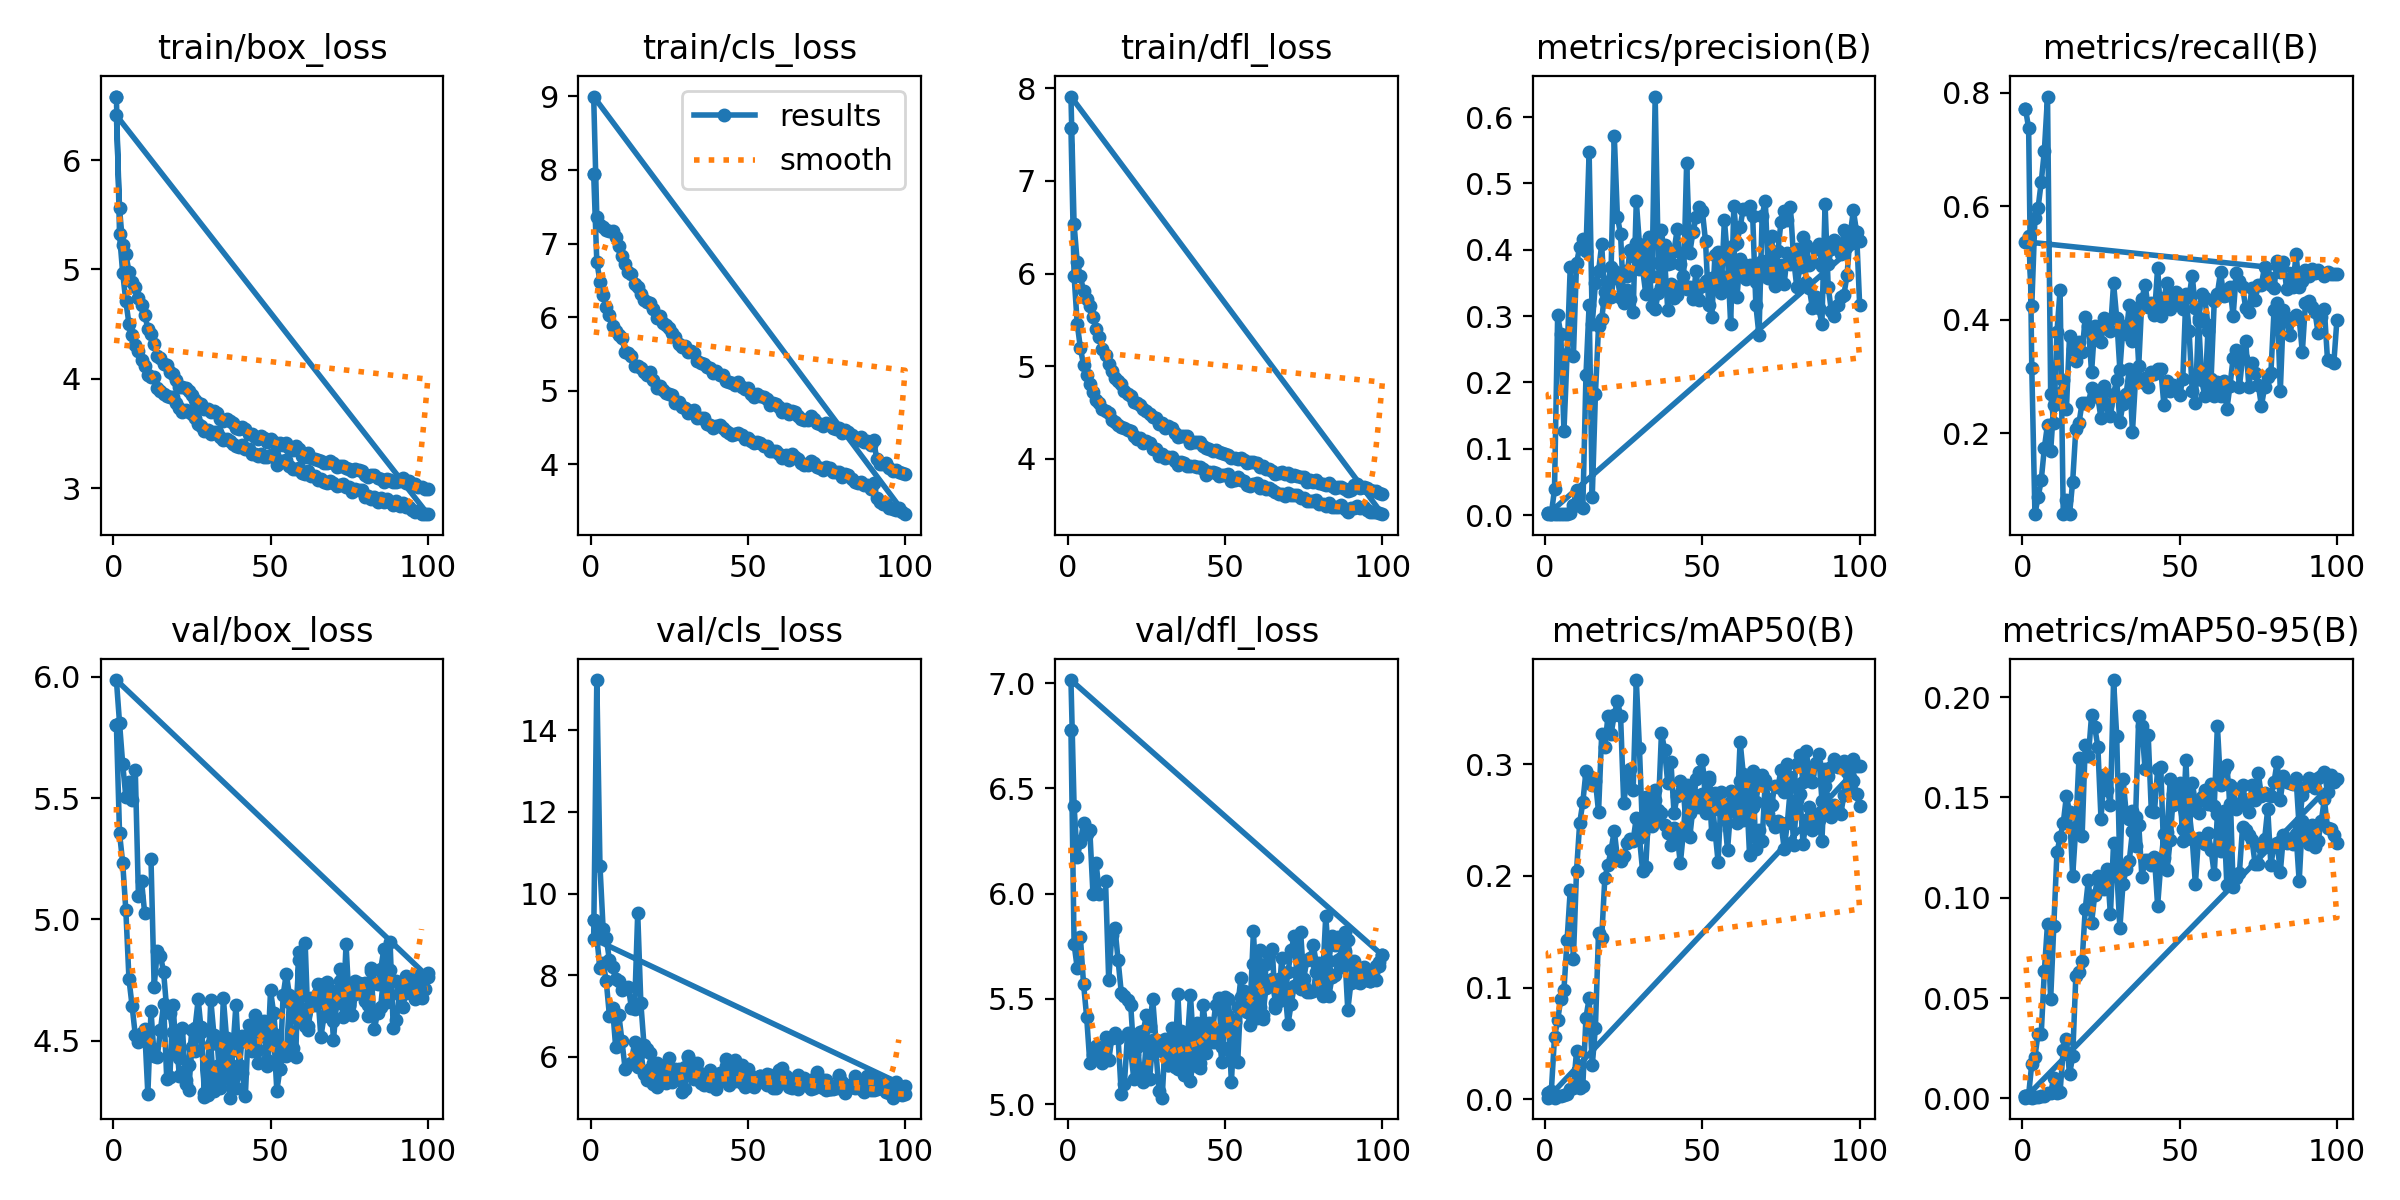

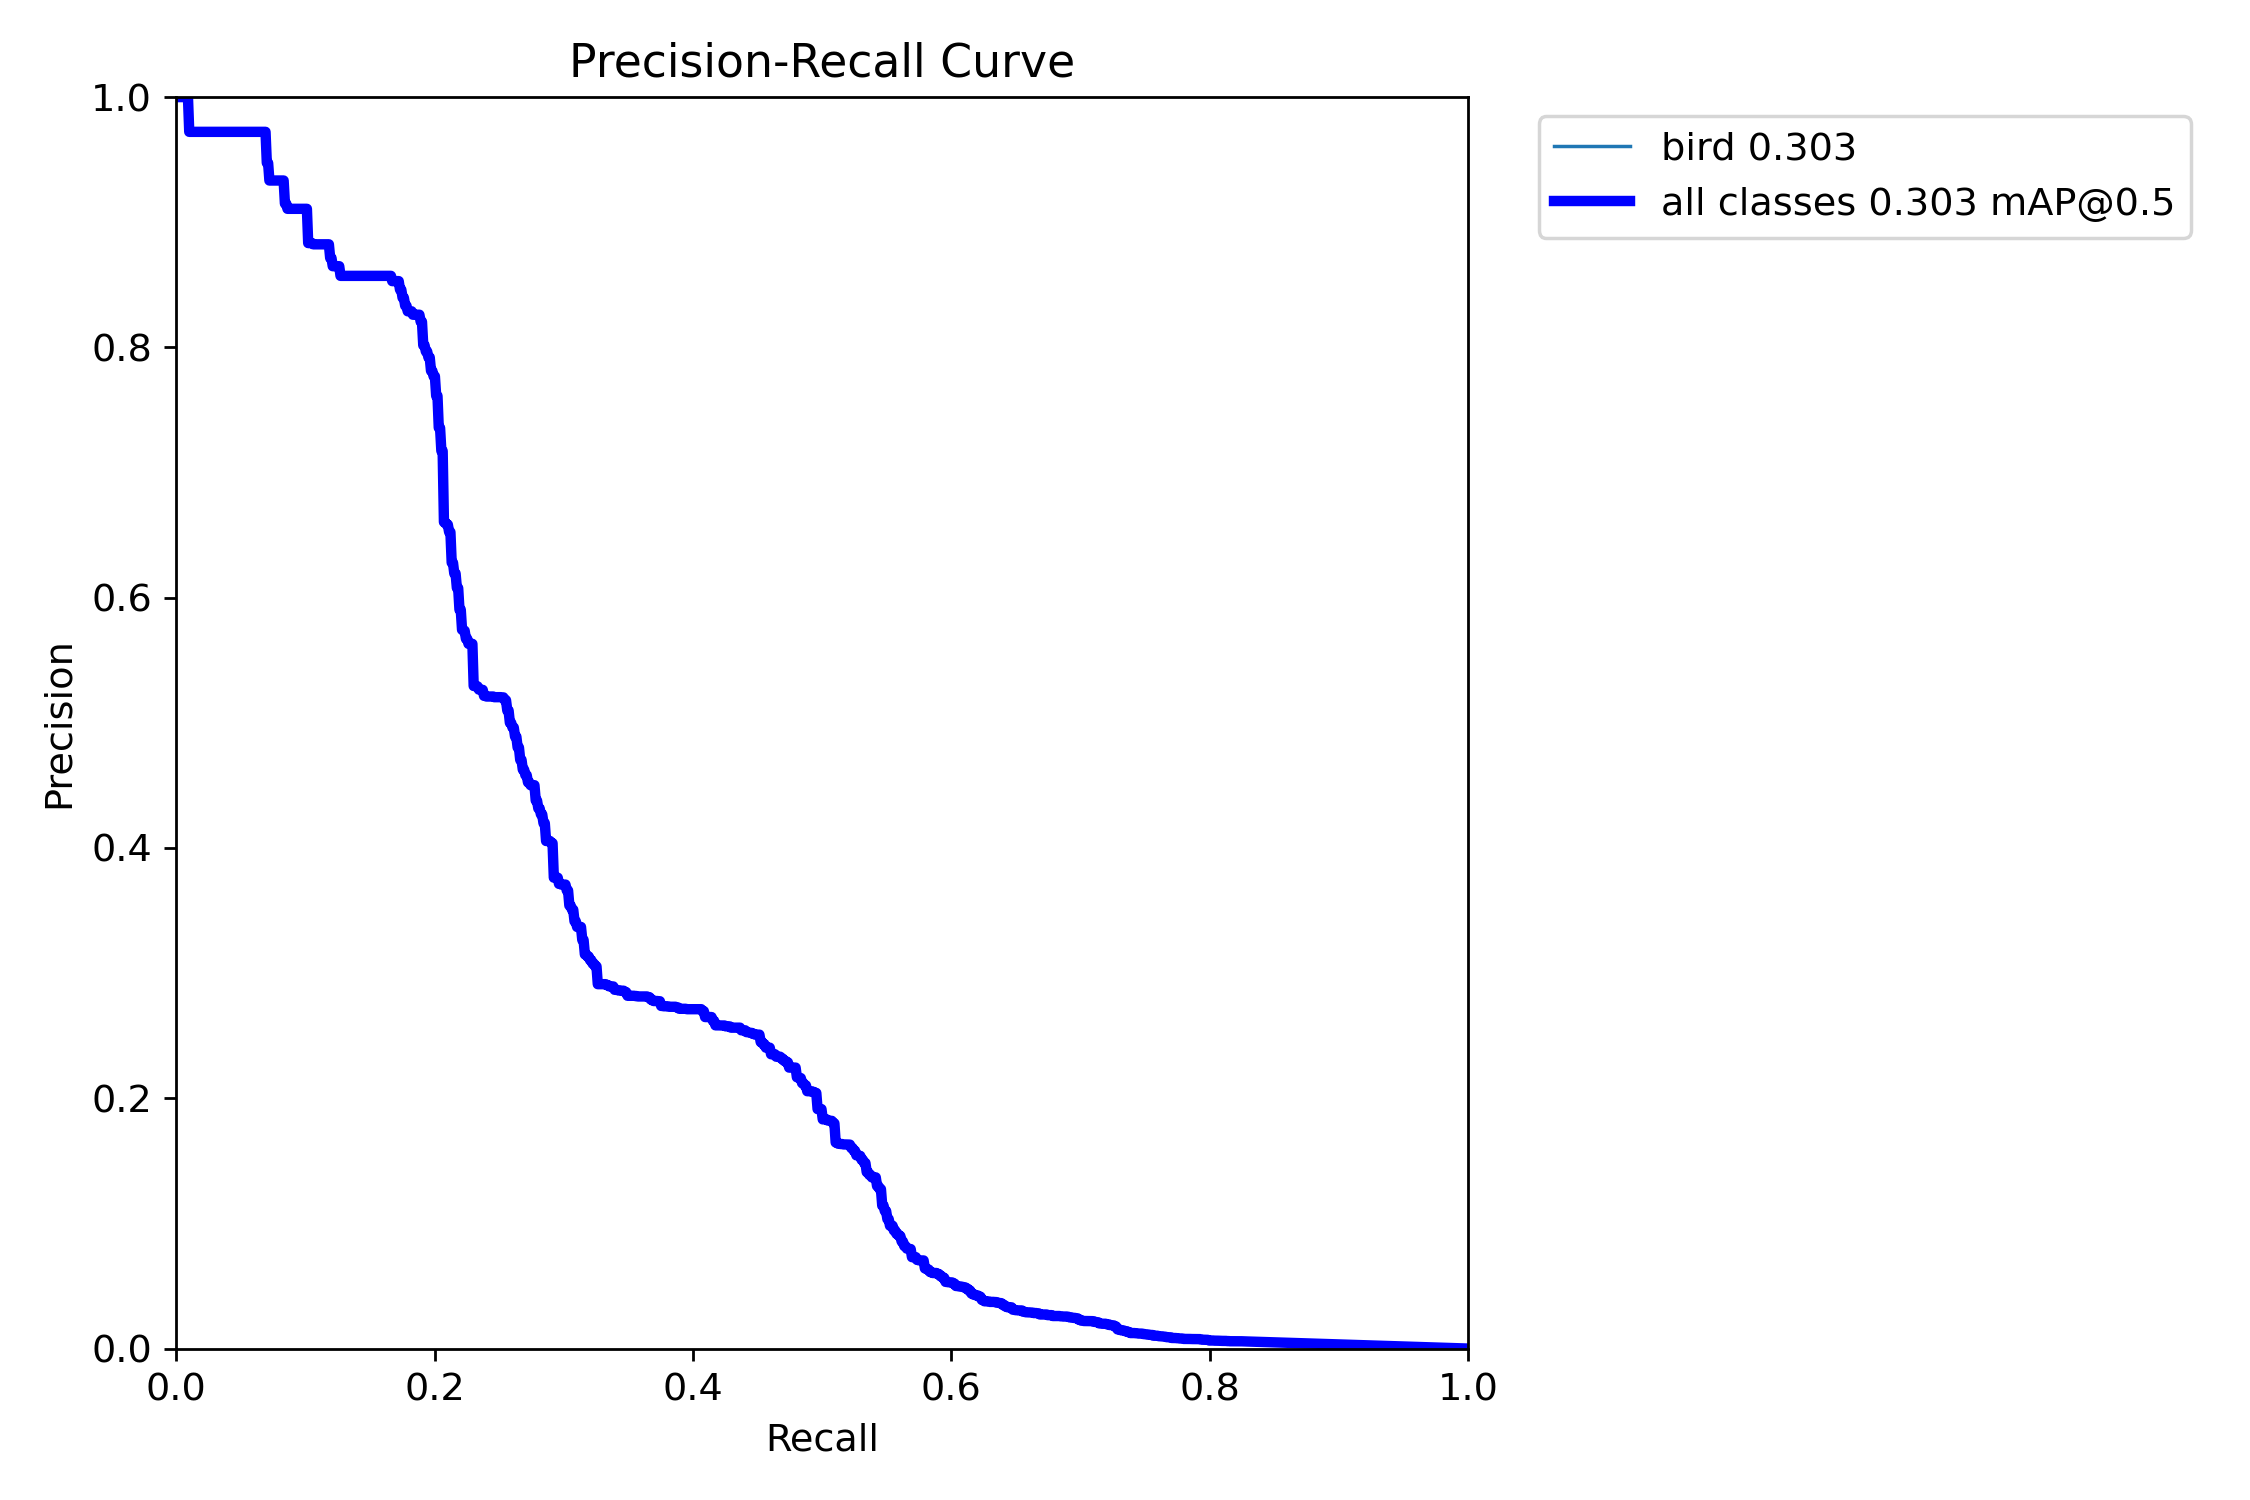

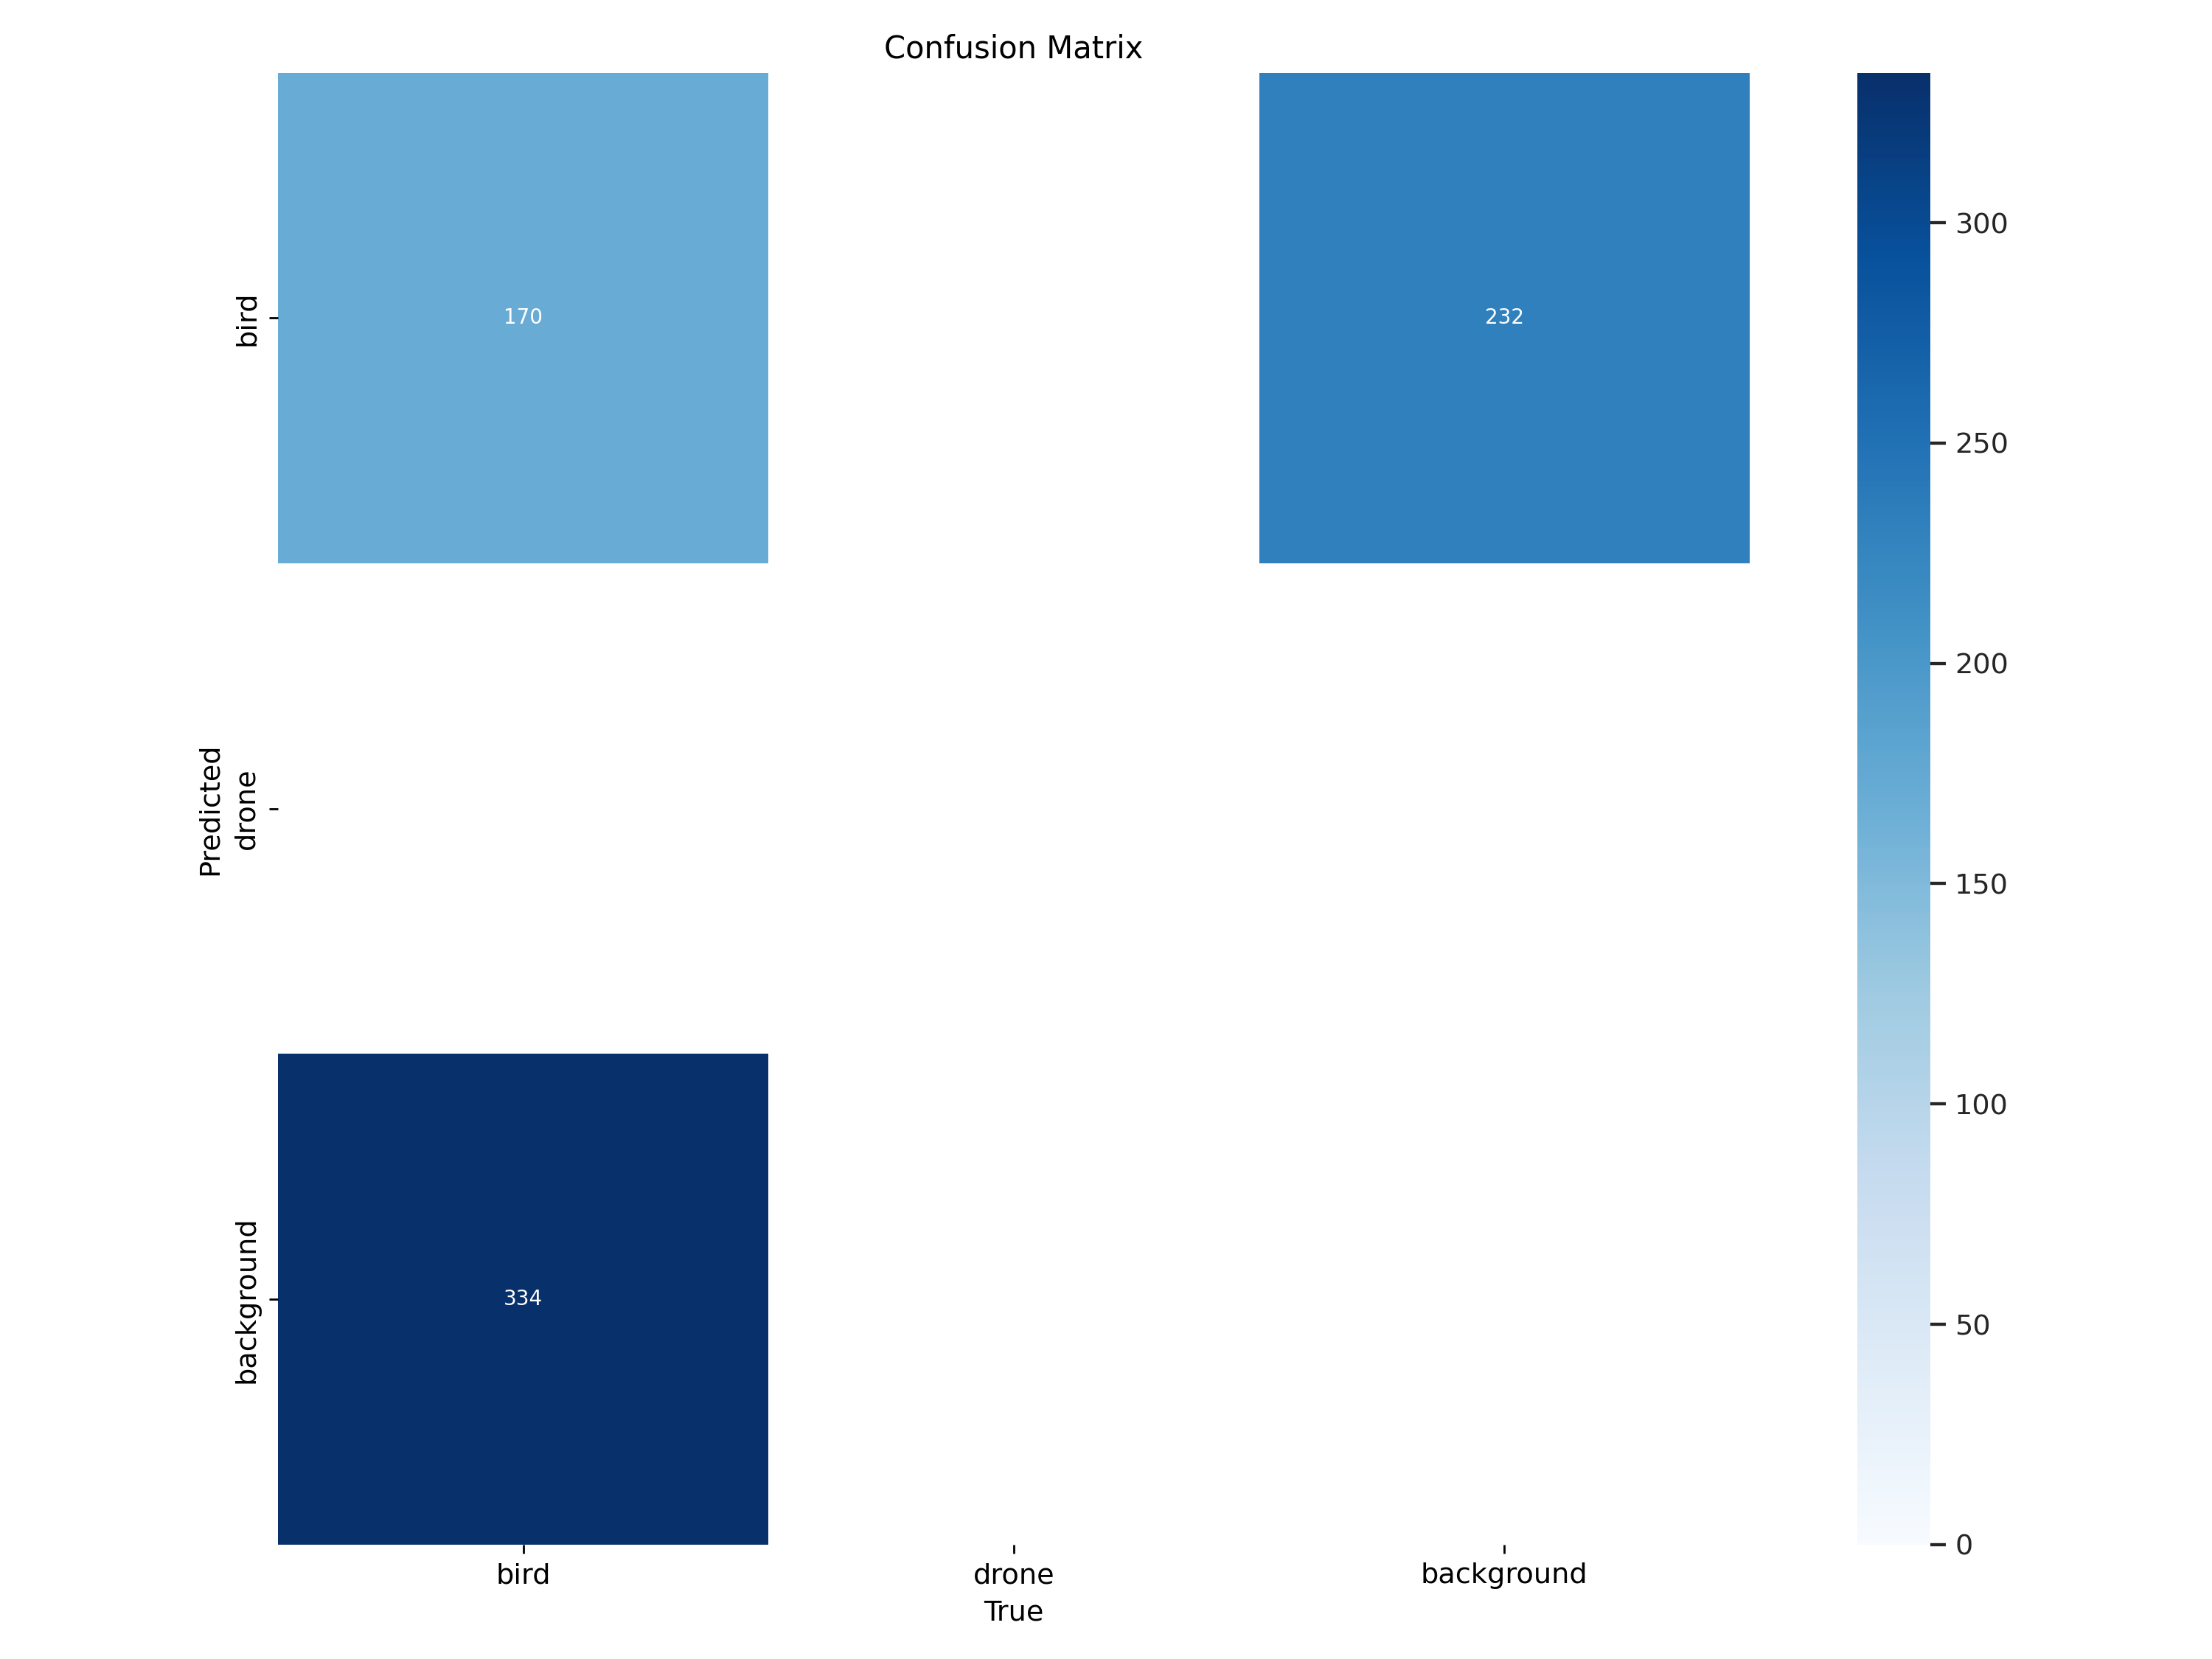

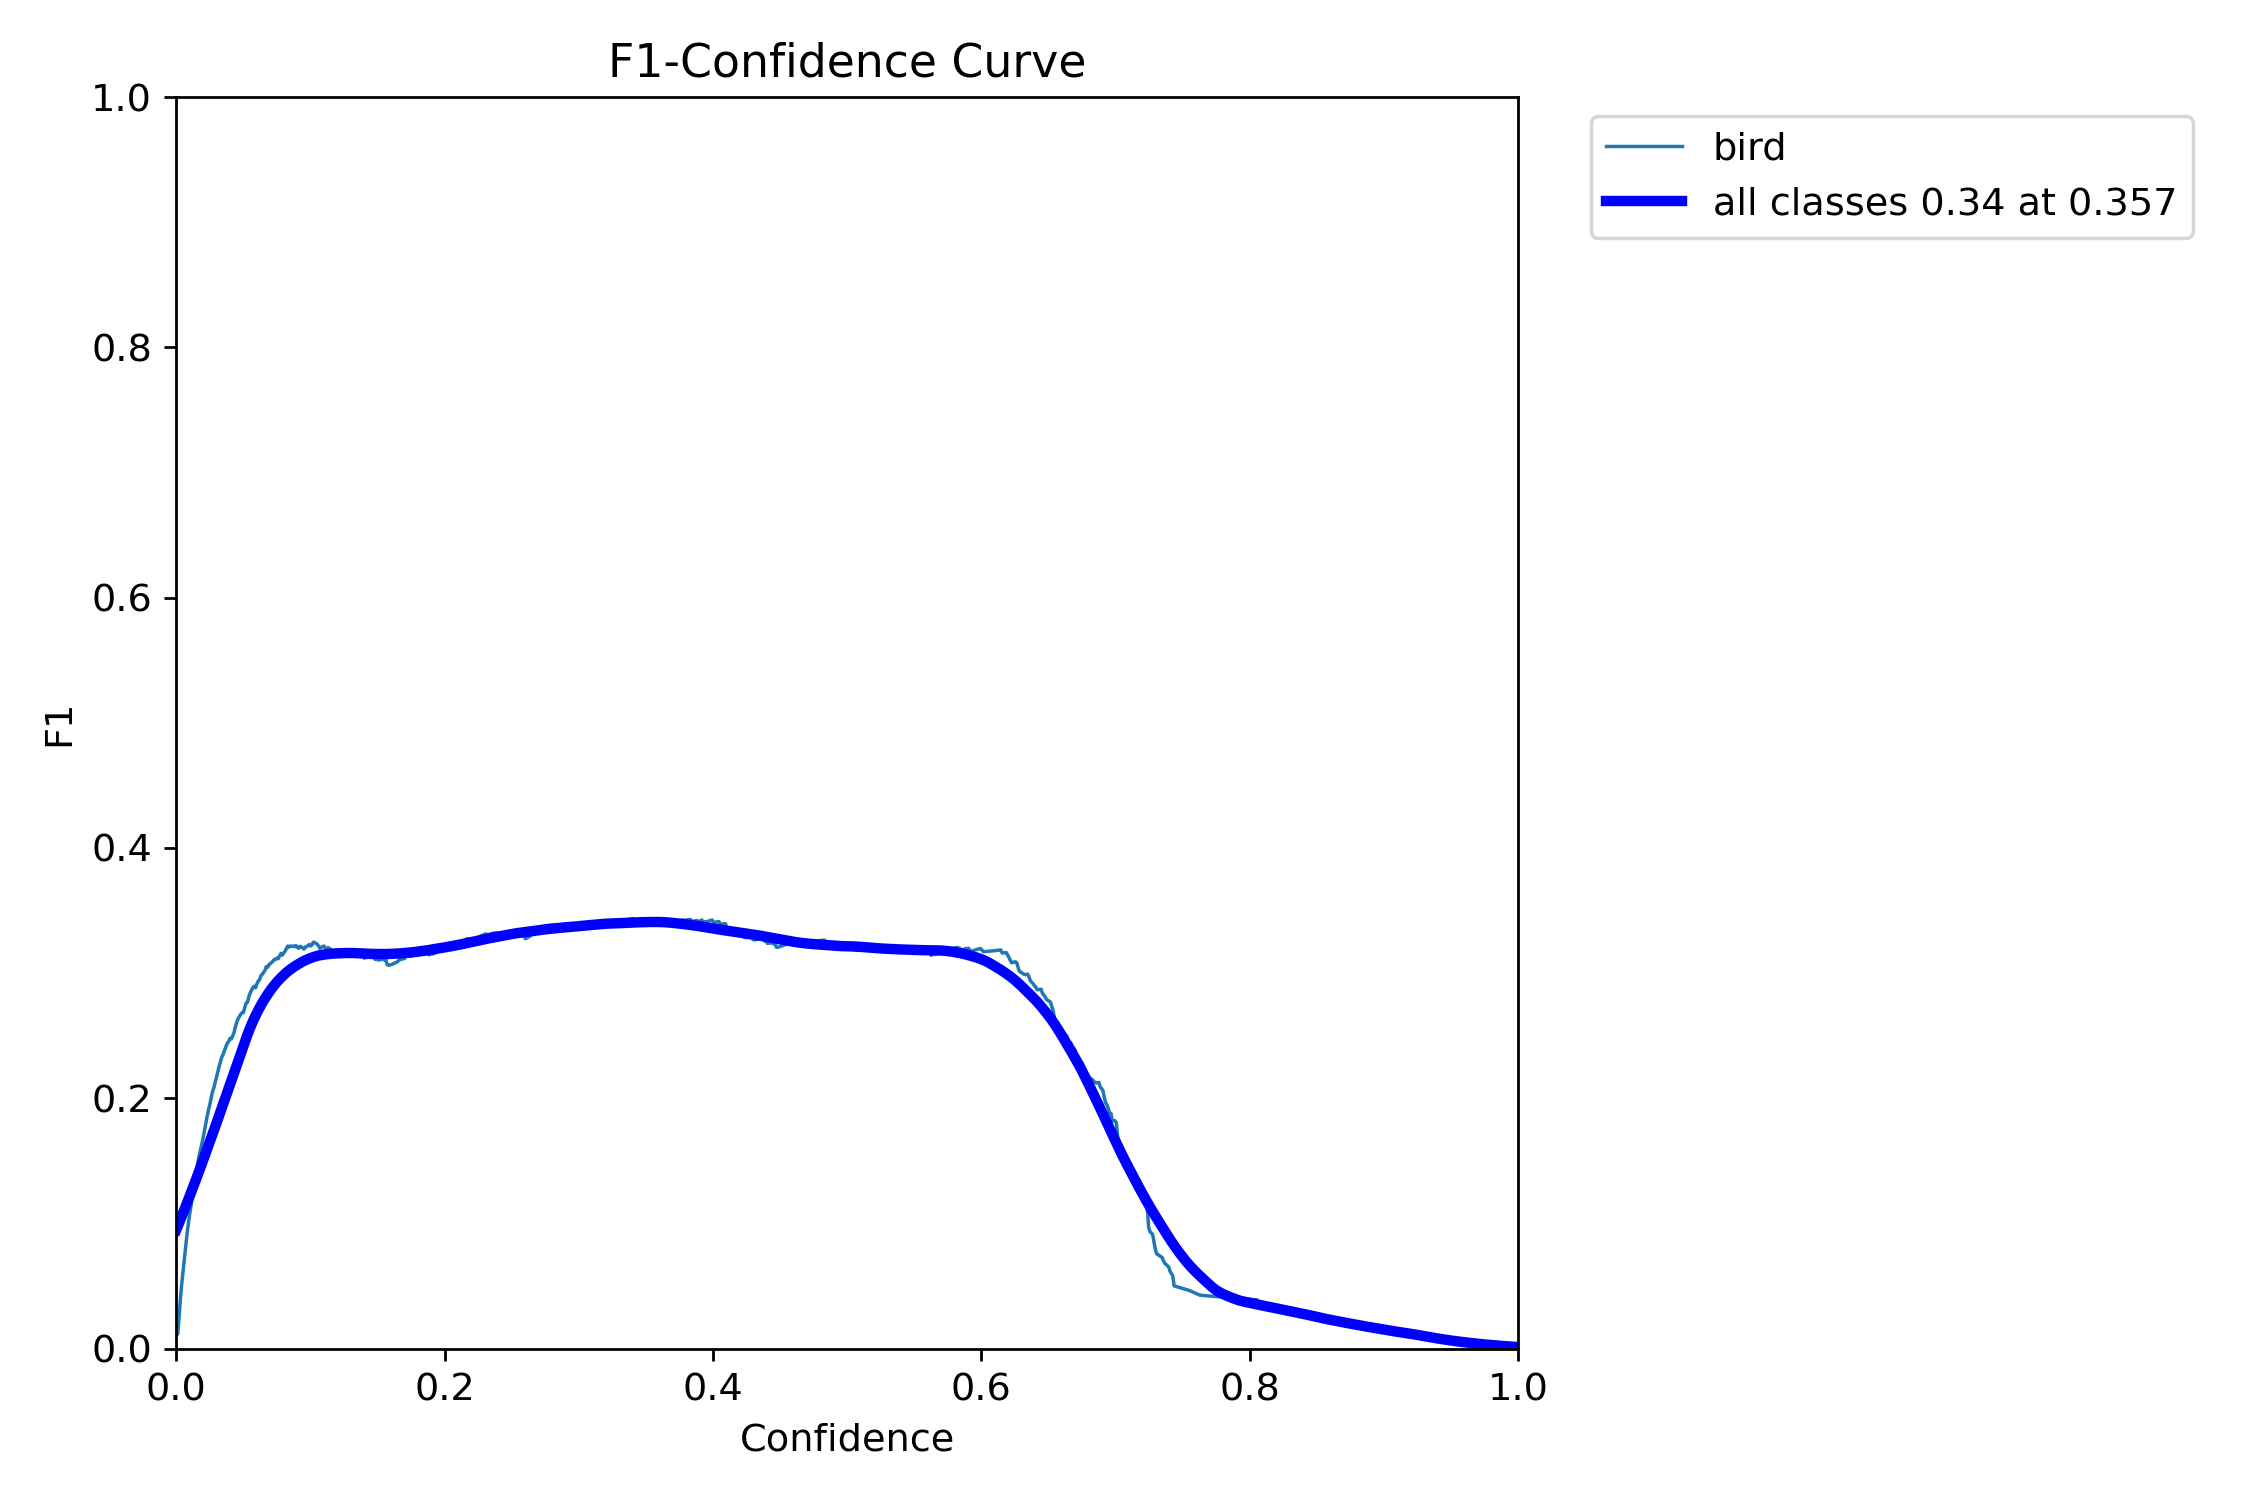